<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance2_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---


🚀 **Avance 2. Ingeniería de características**:

- Crear nuevas características para mejorar el rendimiento de los modelos.
- Mitigar el riesgo de características sesgadas y acelerar la convergencia de algunos algoritmos.

📑 **Asignatura:** Proyecto Integrador

📘 **Proyecto:** LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo:** 44

🧑 **Alumnos:**
> Alberto José García Porras (Matrícula No. **A01793509**)

>  Erick Johan Najera Olivero (Matrícula No. **A01793506**)

>  Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:
> Dra. Grettel Barceló Alonso

> Dr. Luis Eduardo Falcón Morales

> Dr. Guillermo Mota

📅 Mayo 12 del 2024

---

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

---
##👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.
---

In [98]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
print("**********************************************")
print(f"El conjunto de datos cargado inicialmente contiene {len(dfCasinoConsumo):,.2f} registros:")
print("**********************************************")

**********************************************
El conjunto de datos cargado inicialmente contiene 884,615.00 registros:
**********************************************


----
<center> 🤔 Matriz de Correlación entre las variables dependientes e independientes
</center>
----

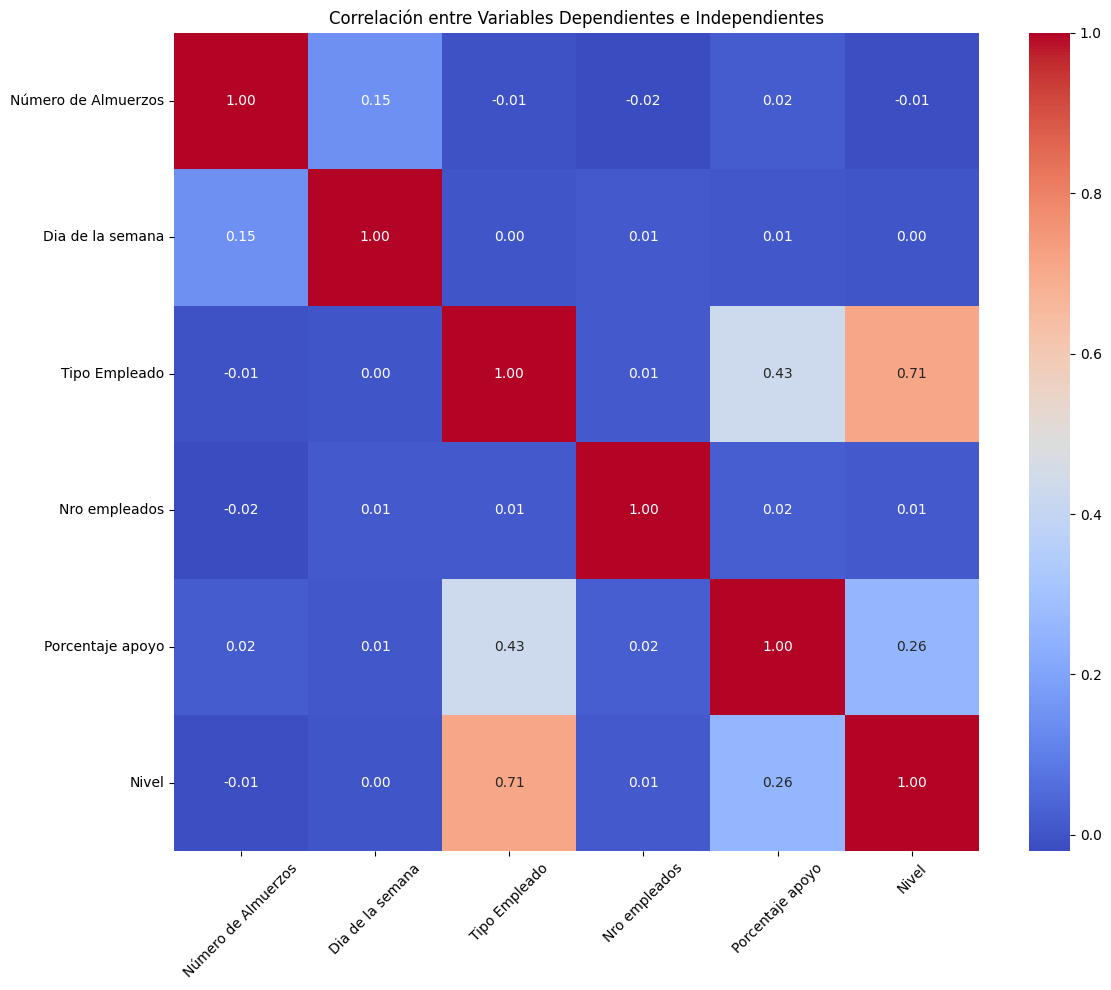

In [99]:
# Preparación de los datos
# Copia del consumo original de comidas relacionadas en el conjunto de datos
dfCasinoConsumoOriginal = dfCasinoConsumo.copy()

# Si la columna necesita ser convertida a datetime (solo si se detectan problemas en la carga directa)
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], errors='coerce')
dfCasinoConsumo['Dia de la semana'] = dfCasinoConsumo['Fecha Consumo'].dt.dayofweek # lunes=0, domingo=6

# Se convierte la variable 'Tipo Empleado' de variable categórica a variable numérica
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes

# Nos aseguramos que 'Nro empleados' y 'Porcentaje apoyo' sean variables numéricas
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')
dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')

# Se pasa a mayuscula todos los datos de la variable
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

# Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO' y crear una copia para evitar SettingWithCopyWarning
dfCasinoConsumo = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

# Creamos una columna auxiliar 'Conteo Almuerzos' con todos los valores iguales a 1 para facilitar la suma
dfCasinoConsumo.loc[:, 'Conteo Almuerzos'] = 1

# Luego, agrupamos los datos por 'Día de la semana' y sumamos el 'Conteo Almuerzos' para obtener el 'Número de Almuerzos' total por cada día de la semana
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Conteo Almuerzos'].transform('sum')

# Continuando con la preparación de los datos:
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes # Convertir 'Tipo Empleado' en variable numérica
dfCasinoConsumo['Detalle'] = pd.Categorical(dfCasinoConsumo['Detalle']).codes  # Convertir 'Detalle' en variable numérica, se dejo solo ALMUERZO
dfCasinoConsumo['Nivel'] = pd.Categorical(dfCasinoConsumo['Nivel']).codes      # Convertir 'Nivel' en variable numérica
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')
dfCasinoConsumo['Porcentaje apoyo'] = pd.to_numeric(dfCasinoConsumo['Porcentaje apoyo'], errors='coerce')

# Cada registro en el dataframe representa un ALMUERZO, CENA, O COMIDA consumida
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Dia de la semana'].transform('count')

# Eliminamos las filas con valores NaN en las columnas relevantes para asegurarnos de que la correlación no se vea afectada por los datos faltantes.
dfCasinoConsumo.dropna(subset=['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel'], inplace=True)

# Finalmente se crea la Matriz de Correlación entre las variables seleccionadas, se quita la variable Detalle
correlation_matrix = dfCasinoConsumo[['Número de Almuerzos', 'Dia de la semana', 'Tipo Empleado', 'Nro empleados', 'Porcentaje apoyo', 'Nivel']].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre Variables Dependientes e Independientes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [100]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
# Copia del Dataframe con el consumo original cargado
dfCasinoConsumoOriginal = dfCasinoConsumo.copy()
print("********************************************************************************************")
print(f"El conjunto de datos cargado inicialmente al DataFrame contiene {len(dfCasinoConsumo):,.2f} registros.")
print("********************************************************************************************")

********************************************************************************************
El conjunto de datos cargado inicialmente al DataFrame contiene 884,615.00 registros.
********************************************************************************************


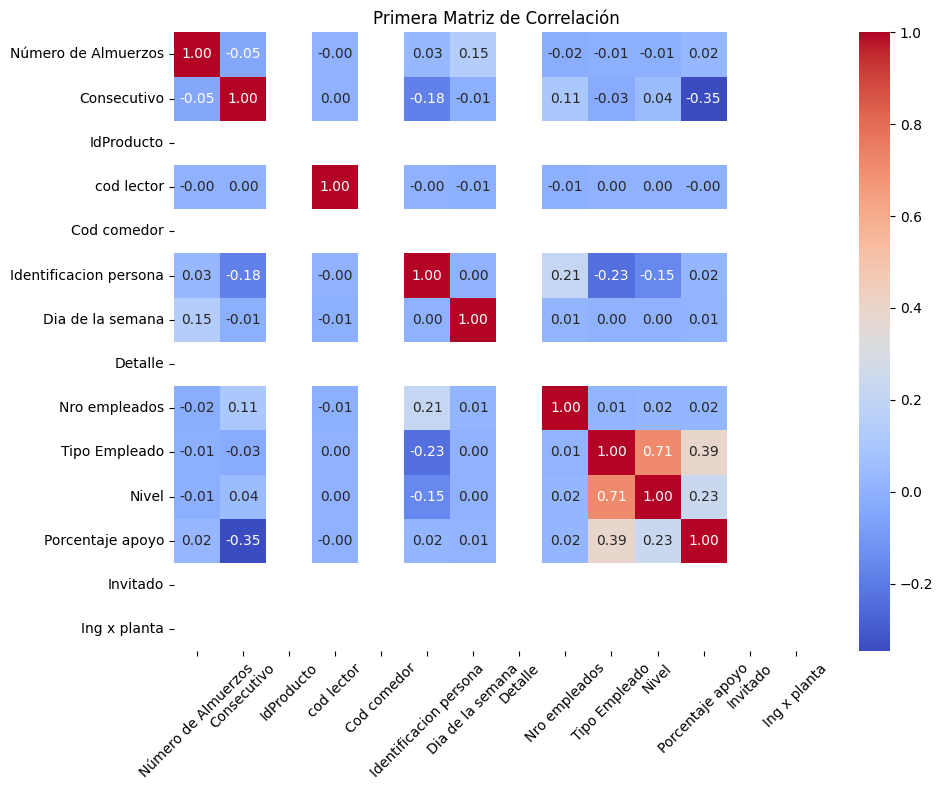

In [101]:
# --------------------------------------
# Preparación de los datos
# --------------------------------------
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], errors='coerce')
dfCasinoConsumo['Dia de la semana'] = dfCasinoConsumo['Fecha Consumo'].dt.dayofweek # lunes=0, domingo=6
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper() # Se pasa a mayuscula todos los datos de la variable
# Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO' y crear una copia para evitar SettingWithCopyWarning
dfCasinoConsumo = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy() # Se dejo solo ALMUERZO
dfCasinoConsumo['Detalle'] = pd.Categorical(dfCasinoConsumo['Detalle']).codes  # Convertir 'Detalle' en variable numérica
dfCasinoConsumo['Nro empleados'] = pd.to_numeric(dfCasinoConsumo['Nro empleados'], errors='coerce')# Nos aseguramos que sea una var numérica
# Se convierte la variable 'Tipo Empleado' de variable categórica a variable numérica
dfCasinoConsumo['Tipo Empleado'] = pd.Categorical(dfCasinoConsumo['Tipo Empleado']).codes
dfCasinoConsumo['Nivel'] = pd.Categorical(dfCasinoConsumo['Nivel']).codes# Se convierte la variable 'Nivel' en variable numérica
dfCasinoConsumo['Porcentaje apoyo'] = pd.Categorical(dfCasinoConsumo['Porcentaje apoyo']).codes

# Creamos una columna auxiliar 'Conteo Almuerzos' con todos los valores iguales a 1 para facilitar la suma
dfCasinoConsumo.loc[:, 'Conteo Almuerzos'] = 1
# Luego, agrupamos los datos por 'Día de la semana' y sumamos el 'Conteo Almuerzos' para obtener el
# 'Número de Almuerzos' total por cada día de la semana
dfCasinoConsumo['Número de Almuerzos'] = dfCasinoConsumo.groupby('Dia de la semana')['Conteo Almuerzos'].transform('sum')

# Finalmente se crea la Matriz de Correlación entre las variables seleccionadas, se quita la variable Detalle
correlation_matrix = dfCasinoConsumo[['Número de Almuerzos','Consecutivo', 'IdProducto', 'cod lector', 'Cod comedor',
                                      'Identificacion persona','Dia de la semana', 'Detalle', 'Nro empleados',
                                      'Tipo Empleado', 'Nivel', 'Porcentaje apoyo', 'Invitado', 'Ing x planta']].corr()


# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Primera Matriz de Correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [102]:
print("*****************************************************************************************************************")
print(f"Ahora el DataFrame contiene {len(dfCasinoConsumo):,.2f} registros, dado que se Filtro en donde Detalle' es 'ALMUERZO'")
print("*****************************************************************************************************************")

*****************************************************************************************************************
Ahora el DataFrame contiene 523,885.00 registros, dado que se Filtro en donde Detalle' es 'ALMUERZO'
*****************************************************************************************************************


---
#####🔎 Al calcular y gráficar la **Primera Matriz de Correlación** se concluye que se deberán eliminar las siguientes variables de acuerdo con los siguientes análisis y conclusiones:
*   **Consecutivo:** Esta variable es un identificador único para cada registro en la base de datos, por lo cual no muestra una correlación significativa con las otras variables del dataset y no aportaría en la predicción del modelo.
*  **IdProducto:** No mostró ningún valor de correlación con las demás variables, al ser un identificador de producto, esta variable no es relevante para predecir el número de almuerzos a adquirir diariamente.
*  **cod lector:** Esta variable presenta un comportamiento similar a la variable "Consecutivo". Almacena el código del dispositivo de lectura del carnet, y efectivamente tampoco aportará al modelo predictivo a desarrollar.
*  **Cod comedor:** Esta variabla almacena el código asignado al comedor dentro de la instalación (Ubicación) y dado que el modelo predictivo no requiere la diferenciación por ubicación o localización, se debe omitir. Adicionalmente, la variable no presentó algún valor de correlación con las demás variables.
*  **Identificacion persona:** Esta variable es otro identificador que no tiene relevancia predictiva directa para el total de almuerzos.
*  **Detalle:** Esta variable no muestra correlaciones en la imagen y no será adecuada para la construcción del modelo. No obstantes a partir de esta variable se filtró el DataFrame para conservar solo las filas donde 'Detalle' es **'ALMUERZO'**, disminuyendo el número total de registros de 884.615 a 523.885.
*  **Invitado:** No mostró ningún valor de correlación con las demás variables, esta variable no es relevante para predecir el número de almuerzos a adquirir diariamente. Esta variable indica sí el consumidor es invitado en la empresa y adicionalmente esta variable solo almacena el valor '0' en todos los registros.
*  **Ing x planta:** No mostró ningún valor de correlación con las demás variables, esta variable no es relevante para predecir el número de almuerzos a adquirir diariamente. Esta variable indica sí el consumidor si el consumo se realzia en las instalaciones de la empresa y adicionalmente esta variable solo almacena el valor '1' en todos los registros.

#####Las variables "Invitado" y "Ing x planta" no tiene variación, dado que todos los valores son 0 o todos son 1, debido a esto, no se puede calcular una correlación estándar. La correlación requiere que haya alguna variabilidad en ambas variables que se están comparando.

#####Por lo anterior se sugieren eliminar estas variables y correr una Segunda Matriz de Correlación para continuar con la Ingenieria de Carácteristicas.
---

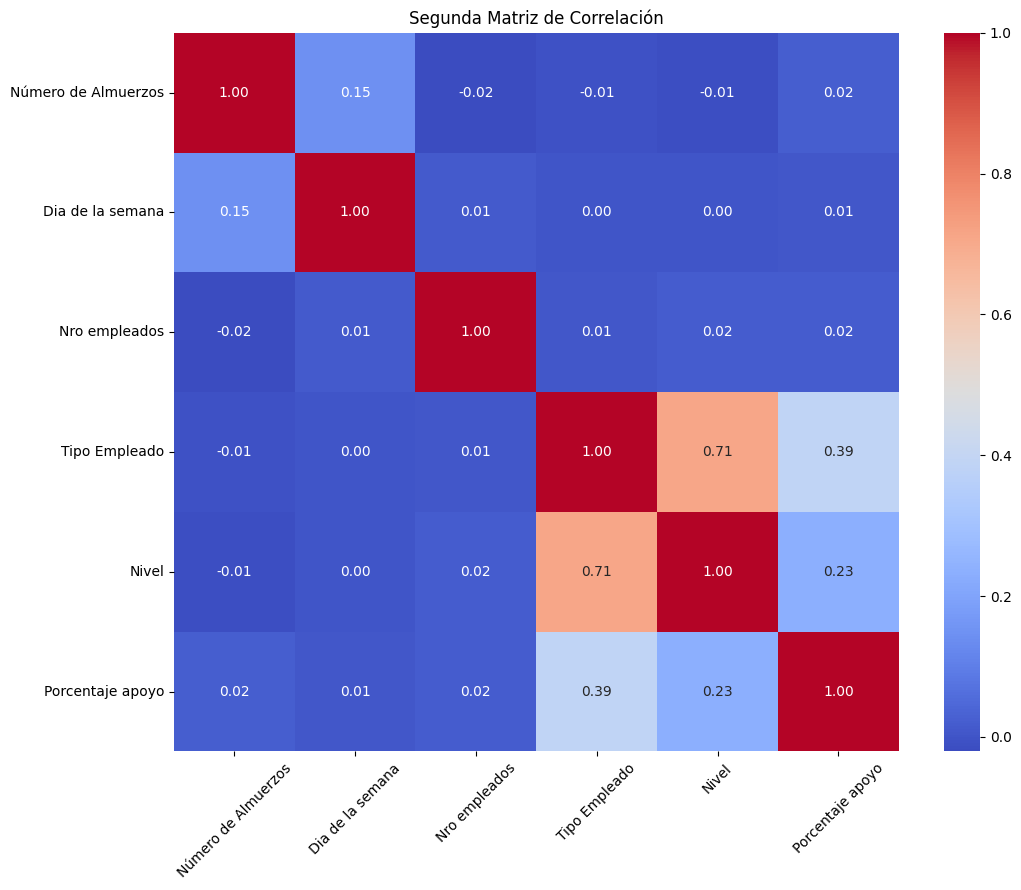

In [104]:
correlation_matrix = dfCasinoConsumo[['Número de Almuerzos', 'Dia de la semana', 'Nro empleados',
                                      'Tipo Empleado', 'Nivel', 'Porcentaje apoyo']].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Segunda Matriz de Correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


---
#####🔎 Algunas de las conclusiones obtenidas al calcular la **Segunda Matriz de Correlación** entre las variables dependiente e independientes, fuerón:
*   La correlación entre **Número de Almuerzos y Día de la Semana (0.15)**:
Esta correlación es débilmente positiva, lo que sugiere una ligera tendencia a que, conforme avanza la semana, podría incrementarse el número de almuerzos, aunque el efecto es muy leve. Esta información puede ser útil, pero no es suficientemente fuerte como para influir significativamente en la planificación de los almuerzos durante la semana.
*   La variable **Detalle** almacena el tipo de comida así: ALMUERZO, CENA, COMIDA, DESAYUNO, MERIENDA AM, MERIENDA PM, REFRIGE PM, REFRIGERIO ESPECIAL PM, y dado que se requiere obtener las cantidades correctas para el servicio de almuerzo del personal y así contribuir a que se reduzca considerablemente el  desperdicio de alimentos en la empresa, se opta por Filtrar el DataFrame para conservar solo las filas donde 'Detalle' es 'ALMUERZO'. De igual manera se observo en la correlación con todos los datos de **la variable Detalle no tenía una incidencia en la correlación, si no que sus valores fueron muy bajos**, por ello se procede a eliminarla de la correlación.
*   Existe una fuerte correlación positiva entre el **Tipo de empleado y su Nivel jerárquico (0.71)**. Esto sugiere que las categorías de empleados están alineadas o son dependientes de los niveles jerárquicos dentro de la organización.
*    Hay una correlación moderada (0.39) entre el **Tipo Empleado** y el **Porcentaje apoyo** que reciben para los almuerzos. Esto puede indicar que diferentes tipos de empleados reciben diferentes niveles de subsidios para las comida, lo cual puede influir en su decisión de almorzar en el comedor de la empresa.
*   Las bajas correlaciones entre el número de empleados y las otras variables, indican que simplemente **más empleados activos en la fecha del consumo no garantiza un aumento o disminución proporcional en el uso del comedor**, lo que sugiere que otros factores contextuales o personales están en juego.
---